**Домашнее задание 3**

В первой части третьего дз предлагается поработать с несколькими датасетами из соревнования [Boston Airbnb Open Data на Kaggle](https://www.kaggle.com/airbnb/boston). Данные можно найти на Kaggle, или по  [ссылке](https://drive.google.com/drive/folders/1lTAxxEwrCkd5WEQMJCJvBsFZc3tXgiyO?usp=sharing). Решите предложенные задания с использованием модуля Pandas (NumPy, разумеется, тоже разрешен).

Использование условий и циклов запрещено (списковые включения это тоже цикл!), за это будут обнуляться баллы.
Все задания равноценны (кроме нулевого, его выполнение необходимо для получения положительной оценки).
В каждой задаче постарайтесь придумать несколько решений. Если вы напишете несколько решений (или несколько способов сделать какую-то часть решения), сравните их производительность с помощью jupyter magics. Решением должен быть Jupyter notebook / ссылка на Colab

In [1]:
import pandas as pd
import numpy as np

In [2]:
df_calendar = pd.read_csv('data/calendar.csv')
df_listing = pd.read_csv('data/listings.csv')
df_review = pd.read_csv('data/reviews.csv')

0. Внимательно посмотрите на данные в таблицах. При попытке посмотреть первые несколько строк в таблице listings с помощью pandas отображаются не все колонки. Сделайте так, чтобы отображались все столбцы:

In [3]:
pd.set_option('display.max_columns', None)

- Для всех ли объявлений есть календарь? - ДА

In [4]:
print(*df_listing['id'].isin(df_calendar['listing_id']).astype(bool).value_counts().index)

True


- Для какой доли объявлений нет ни одного отзыва? ~21%

   первый способ (быстрее):

In [5]:
%%time

id_rvw = set(df_review['listing_id'])
id_lst = set(df_listing['id'])
prc_no_review = (1 - len(id_rvw) / len(id_lst))*100
print('percentage without any review:', prc_no_review)

percentage without any review: 21.087866108786613
CPU times: user 6.61 ms, sys: 1.2 ms, total: 7.81 ms
Wall time: 7.3 ms


   второй способ (оказался медленнее):

In [6]:
%%time

cnt_no_review = (len(df_listing[df_listing['number_of_reviews'] == 0])/ df_listing.shape[0])*100
print(cnt_no_review)

21.08786610878661
CPU times: user 1.88 ms, sys: 1.22 ms, total: 3.1 ms
Wall time: 2.54 ms


- Сколько объявлений не были доступны для сдачи ни разу за представленный период? - 19

In [7]:
len(df_listing[df_listing['calendar_updated'] == 'never'])

19

1. Как зовут владельца, у недвижимости которого за отчетный период была наибольшая разница между максимальной и минимальной ценой? - Hilary

- создаем копию, чтобы работать с меньшей dataframe:

In [8]:
df_price = df_calendar[['listing_id', 'price']].copy()

- форматируем цену

In [9]:
df_price['price'] = df_price['price'].str.replace('$', '')
df_price['price'] = df_price['price'].str.replace(',', '')
df_price['price'] = df_price['price'].astype(float)

/var/folders/vq/83rh7mkj0gj6bpm6h82_r53c0000gn/T/ipykernel_55570/4235160620.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_price['price'] = df_price['price'].str.replace('$', '')


- создаем новую колонку разницы, сгруппировав по host_id с мин и макс значениями

In [10]:
df_price = df_price.groupby('listing_id')['price'].agg([min, max])
df_price['difference'] = df_price['max'] - df_price['min']
df_price

,min,max,difference
listing_id,,,
3353,32.0,36.0,4.0
5506,145.0,275.0,130.0
6695,195.0,325.0,130.0
6976,65.0,65.0,0.0
8792,154.0,154.0,0.0
...,...,...,...
14924831,132.0,180.0,48.0
14928000,55.0,55.0,0.0
14928333,70.0,113.0,43.0


In [11]:
max_dif = max(df_price['difference'])
df_price = df_price[df_price.difference == max_dif]

In [12]:
host_id = df_price.index[0]
df_price = df_listing.loc[df_listing['id'] == host_id]

выводим имя:

In [13]:
print(*df_price['host_name'])

Hilary


2. В таблице listings достаточно много самых разных колонок. В частности, есть host_listings_count, host_total_listings_count и calculated_host_listings_count. По названию понятно, что это "какое-то" число объявлений хозяина недвижимости, но какое?

    Внимание вопрос. Является ли какое-то из этих чисел количеством объявлений из listings для каждого хозяина недвижимости? 

    Приветствуются промежуточные вычисления и рассуждения по этому вопросу. Например, было бы круто проверить, что для всех записей одного и того же хозяина одинаковые значения в указанных выше трех столбцах

In [14]:
df_count = df_listing[['host_id', 'host_listings_count', 
                       'host_total_listings_count', 'calculated_host_listings_count']].copy()

In [15]:
len(df_count[(df_count['host_listings_count'] == df_count['host_total_listings_count']) == False])

0

полагаю, host_listings_count и host_total_listings_count - общее количество объявлений хоста, потому что данные этих колонок одинаковы

In [16]:
len(df_count[(df_count['host_listings_count'] == df_count['calculated_host_listings_count']) == False])

1027

In [17]:
df_count = df_listing.groupby('host_id').agg({'id': 'count'})

In [18]:
df_count = pd.merge(df_listing[['host_id', 'host_listings_count', 'calculated_host_listings_count']], 
                           df_count, on='host_id', how='left')


проверяем на индентичность (есть ли различные значения 0 - столбцы идентичны):


In [19]:
len(df_count[(df_count['calculated_host_listings_count'] == df_count['id']) == False])

0

calculated_host_listings_count - количество объявлений для каждого хозяина недвижимости, тк данные столбцов совпадают

- Сколько в среднем объектов недвижимости у хозяина из числа указанных в listings? ~ 12

In [20]:
df_count['calculated_host_listings_count'].mean()

12.733891213389121

- А сколько максимально? - 136

In [21]:
df_count['calculated_host_listings_count'].max()

136

3. Коррелируют ли средняя цена на недвижимость за всё время наблюдений и количество отзывов на неё? Иными словами, если средняя цена квартиры больше, то на неё оставляют больше или меньше отзывов?

отформатируем данные:

In [22]:
df_listing['price'] = df_listing['price'].str.replace('$', '')
df_listing['price'] = df_listing['price'].str.replace(',', '')
df_listing['price'] = df_listing['price'].astype(float)

/var/folders/vq/83rh7mkj0gj6bpm6h82_r53c0000gn/T/ipykernel_55570/3807436051.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_listing['price'] = df_listing['price'].str.replace('$', '')


изобразим график корреляции и посчитаем ее двумя вариантами:

In [23]:
import matplotlib.pyplot as plt

<Axes: xlabel='price', ylabel='number_of_reviews'>

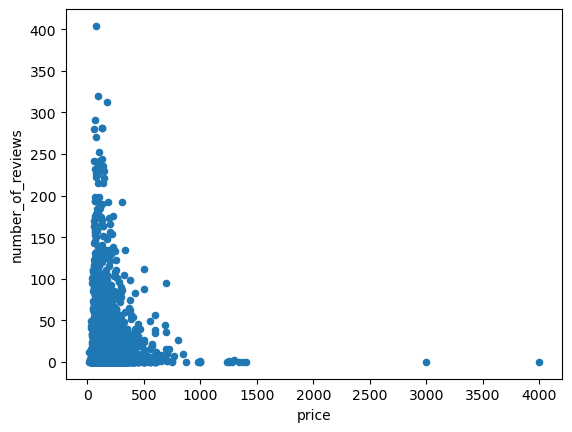

In [24]:
df_listing.plot(x='price', y='number_of_reviews', kind='scatter')

первый способ: ~0,1

In [25]:
%%time
print(df_listing['price'].corr(df_listing['number_of_reviews']))

-0.09642705760760048
CPU times: user 1.06 ms, sys: 1.11 ms, total: 2.17 ms
Wall time: 1.01 ms


второй способ: ~0,1

In [26]:
%%time
np.corrcoef(df_listing['price'], df_listing['number_of_reviews'])[0][1]

CPU times: user 477 µs, sys: 499 µs, total: 976 µs
Wall time: 419 µs


-0.09642705760760048

значения совпадают: слабая отрицательная корреляция 
= увеличение цены ведет почти не ведет к закономерному уменьшению количества отзывов

Иными словами, если средняя цена квартиры больше, то на неё оставляют меньше отзывов

4. Давайте рассмотрим кейс, в котором имена хозяина недвижимости и гостя совпадают.

-  Как зовут хозяйку, у которой было в качестве гостей больше всего тёзок? 

In [27]:
df_listrev = pd.merge(df_listing[['id', 'host_name']].sort_values(by='id'),
                      df_review[['listing_id', 'reviewer_name', 'comments']].sort_values(by='listing_id'),
                      left_on = 'id', right_on = 'listing_id', how = 'inner')

создали новую табличку, совместив по иннеру listing и review

In [28]:
df_listrev = df_listrev.query('reviewer_name == host_name').groupby(by='host_name').agg({'reviewer_name': 'count'})

отсортировали

In [29]:
df_listrev = df_listrev.sort_values(by='reviewer_name', ascending=False)

In [30]:
print(df_listrev.index[0])

Tom


Том - мужчина, но параметра пола нет, ищем дальше

In [31]:
name = df_listrev.index[1]
print(df_listrev.index[1])

Susan


Susan подходит

- Что все её гости отмечали в качестве плюсов сдаваемой недвижимости?


In [32]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

выводим 4 рандомных отзыва

In [33]:
df_listrev = pd.merge(df_listing[['id', 'host_name']].sort_values(by='id'),
                      df_review[['listing_id', 'comments']].sort_values(by='listing_id'),
                      left_on = 'id', right_on = 'listing_id', how = 'inner')
df_listrev = df_listrev[df_listrev['host_name'] == name]

print((df_listrev['comments'].sample(4)).to_string(index=False))

This was my second experience staying with Susan.  This was an extended booking - Susan still welcomed me with open arms, helped carry my luggage to my room and was an overall wonderful host.  Due to this being an extended booking, we had multiple interactions over several months and I must say Susan (and her puppy Zoey) were a joy to speak with.  \r\n\r\nA former caterer, Susan's Sunday breakfasts were amazing, very filling and special (especially the French Toast and bacon!)  The bed itself was very comfortable, the bathroom sparkling, and the house is a very  ascetically pleasing place and It would be my pleasure to stay their again!
                                                                                                                                                                                                                                                                                                                      Susan is a wonderfull hoster, the house is cl